### NAMLSS Code & Helper Functions

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean() 

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [49]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def F2(X):
    return (3 - 3 * X ** 2).squeeze()

def F3(X):
    return (12 * (X - 0.5) ** 2).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

def S2(X):
    return (1.2 - 1/2 * X).squeeze()

def S3(X):
    return (X/X).squeeze()

### Simulation using 3 Covariates

In [50]:
import random
import numpy as np
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


def simulation_run():

    ########## Drawing Covariate Samples ##########
    n_train, n_val, n_test = 10000, 10000, 10000
    prop_corrupt = 0.1
    n_var = 3
    Uniform = dist.Uniform(0, 1)

    X_train = Uniform.sample(sample_shape = [n_train, n_var])
    X_val = Uniform.sample(sample_shape = [n_val, n_var])
    X_test = Uniform.sample(sample_shape = [n_test, n_var])

    ########## Training Dataset ##########
    F1_train = F1(X_train[:,0])
    F2_train = F2(X_train[:,1])
    F3_train = F3(X_train[:,2])

    S1_train = S1(X_train[:,0])
    S2_train = S2(X_train[:,1])
    S3_train = S3(X_train[:,2])

    y_train = torch.normal(mean = F1_train + F2_train + F3_train, std = S1_train + S2_train + S3_train)
    corrupted_train_indices = torch.tensor(random.sample(range(1, n_train), int(n_train * prop_corrupt)))
    y_train[corrupted_train_indices] = torch.normal(torch.ones(len(corrupted_train_indices)) * 15, torch.ones(len(corrupted_train_indices)) * 2) # TODO: Bessere Outlier
    y_train = y_train.view(n_train, 1)

    intact_train_indices = torch.ones(n_train, dtype=bool)
    intact_train_indices[corrupted_train_indices] = False

    ########## Validation Dataset ###########
    F1_val = F1(X_val[:,0])
    F2_val = F2(X_val[:,1])
    F3_val = F3(X_val[:,2])

    S1_val = S1(X_val[:,0])
    S2_val = S2(X_val[:,1])
    S3_val = S3(X_val[:,2])

    y_val =  + torch.normal(mean = F1_val + F2_val + F3_val, std = S1_val + S2_val + S3_val)
    corrupted_val_indices = torch.tensor(random.sample(range(1, n_val), int(n_val * prop_corrupt)))
    y_val[corrupted_val_indices] = torch.normal(torch.ones(len(corrupted_val_indices)) * 15, torch.ones(len(corrupted_val_indices)) * 2) # TODO: Bessere Outlier
    y_val = y_val.view(n_val, 1)

    ########## Testing Dataset ##########
    F1_test = F1(X_test[:,0])
    F2_test = F2(X_test[:,1])
    F3_test = F3(X_test[:,2])
    F_test = np.column_stack((F1_test, F2_test, F3_test))

    S1_test = S1(X_test[:,0])
    S2_test = S2(X_test[:,1])
    S3_test = S3(X_test[:,2])
    S_test = np.column_stack((S1_test, S2_test, S3_test))

    y_test = torch.normal(mean = F1_test + F2_test + F3_test, std = S1_test + S2_test + S3_test)
    corrupted_test_indices = torch.tensor(random.sample(range(1, n_test), int(n_test * prop_corrupt)))
    y_test[corrupted_test_indices] = torch.normal(torch.ones(len(corrupted_test_indices)) * 15, torch.ones(len(corrupted_test_indices)) * 2) # TODO: Bessere Outlier

    y_test = y_test.view(n_test, 1)
    
    ########## Scaling the Data ##########
    scaler = StandardScaler()
    scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

    X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
    X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
    X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

    y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
    y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
    y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

    ########## Training the Networks ##########
    nam = NormalNAMLSS(3)
    nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

    robust_nam = NormalNAMLSS(3)
    robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

    strict_nam = NormalNAMLSS(3)
    strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

    ########## Predicting Parameters on Scaled Data ##########
    mu, sigma = nam.predict(X_test_scaled)
    rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
    strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

    mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
    robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
    strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

    ########## Rescaling Predicted Parameters ##########
    mu = mu * scaler3.scale_ + scaler3.mean_
    rob_mu = rob_mu * scaler3.scale_ + scaler3.mean_
    strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

    sigma = sigma * scaler3.scale_
    rob_sigma = rob_sigma * scaler3.scale_
    strict_sigma = strict_sigma * scaler3.scale_

    mu_components = mu_components * scaler3.scale_ + scaler3.mean_
    robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
    strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

    sigma_components = sigma_components * scaler3.scale_
    robust_sigma_components = robust_sigma_components * scaler3.scale_
    strict_sigma_components = strict_sigma_components * scaler3.scale_

    ########## Return Dictionary with Relevant Information ##########
    run_result_dict = {
        "X_test": X_test,
        "y_test": y_test,
        "F_test":F_test,
        "S_test":S_test,
        "mu_components": mu_components,
        "robust_mu_components": robust_mu_components,
        "strict_mu_components": strict_mu_components,
        "sigma_components": sigma_components,
        "robust_sigma_components": robust_sigma_components,
        "strict_sigma_components": strict_sigma_components}
    
    return run_result_dict

In [51]:
def simulation(runs):
    result_list = [simulation_run() for _ in range(runs)]
    return result_list

In [52]:
import numpy as np
import pandas as pd

def get_mse(simulation_run_dict):

    F_test = simulation_run_dict["F_test"]
    mu_components = simulation_run_dict["mu_components"]
    robust_mu_components = simulation_run_dict["robust_mu_components"]
    strict_mu_components = simulation_run_dict["strict_mu_components"]

    S_test = simulation_run_dict["S_test"]
    sigma_components = simulation_run_dict["sigma_components"]
    robust_sigma_components = simulation_run_dict["robust_sigma_components"]
    strict_sigma_components = simulation_run_dict["strict_sigma_components"] 

    # Mu
    mean_mse_values = {
        "X1": [
            np.mean(((mu_components[:, 0] - mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2),
            np.mean(((robust_mu_components[:, 0] - robust_mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2),
            np.mean(((strict_mu_components[:, 0] - strict_mu_components[:, 0].mean()) - (F_test[:,0] - F_test[:,0].mean())) ** 2)
        ],
        "X2": [
            np.mean(((mu_components[:, 1] - mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2),
            np.mean(((robust_mu_components[:, 1] - robust_mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2),
            np.mean(((strict_mu_components[:, 1] - strict_mu_components[:, 1].mean()) - (F_test[:,1] - F_test[:,1].mean())) ** 2)
        ],
        "X3": [
            np.mean(((mu_components[:, 2] - mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2),
            np.mean(((robust_mu_components[:, 2] - robust_mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2),
            np.mean(((strict_mu_components[:, 2] - strict_mu_components[:, 2].mean()) - (F_test[:,2] - F_test[:,2].mean())) ** 2)
        ]
    }

    # Sigma
    sigma_mse_values = {
        "X1": [
            np.mean(((sigma_components[:, 0] - sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean()) - (S_test[:,0] - S_test[:,0].mean())) ** 2)
        ],
        "X2": [
            np.mean(((sigma_components[:, 1] - sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean()) - (S_test[:,1] - S_test[:,1].mean())) ** 2)
        ],
        "X3": [
            np.mean(((sigma_components[:, 2] - sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2),
            np.mean(((robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2),
            np.mean(((strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean()) - (S_test[:,2] - S_test[:,2].mean())) ** 2)
        ]
    }

    mean_mse_df = pd.DataFrame(mean_mse_values, index=["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_values, index=["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE":mean_mse_df,
            "Sigma_MSE":sigma_mse_df}

In [53]:
def simulation_mse_tables(simulation_runs):
    mean_mse_list = []
    sigma_mse_list = []
    
    for run_dict in simulation_runs:

        mse_results = get_mse(run_dict)
        
        mean_mse_list.append(mse_results["Mean_MSE"].values)
        sigma_mse_list.append(mse_results["Sigma_MSE"].values)
    
    mean_mse_array = np.array(mean_mse_list)  # Shape: (num_runs, 3, 3)
    sigma_mse_array = np.array(sigma_mse_list)

    # Compute averages across simulation runs
    mean_mse_avg = np.mean(mean_mse_array, axis = 0)
    sigma_mse_avg = np.mean(sigma_mse_array, axis = 0)

    # Convert back to DataFrame
    mean_mse_df = pd.DataFrame(mean_mse_avg, columns = ["X1", "X2", "X3"], index = ["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_avg, columns = ["X1", "X2", "X3"], index = ["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE_Avg": mean_mse_df, "Sigma_MSE_Avg": sigma_mse_df}


In [ ]:
simulation_list = simulation(10)

Epoch 0 - Train Loss: 1.8015 - Val Loss: 1.7984
Epoch 1 - Train Loss: 1.7973 - Val Loss: 1.7942
Epoch 2 - Train Loss: 1.7931 - Val Loss: 1.7901
Epoch 3 - Train Loss: 1.7889 - Val Loss: 1.7859
Epoch 4 - Train Loss: 1.7848 - Val Loss: 1.7818
Epoch 5 - Train Loss: 1.7807 - Val Loss: 1.7778
Epoch 6 - Train Loss: 1.7767 - Val Loss: 1.7738
Epoch 7 - Train Loss: 1.7727 - Val Loss: 1.7698
Epoch 8 - Train Loss: 1.7687 - Val Loss: 1.7658
Epoch 9 - Train Loss: 1.7648 - Val Loss: 1.7619
Epoch 10 - Train Loss: 1.7609 - Val Loss: 1.7581
Epoch 11 - Train Loss: 1.7570 - Val Loss: 1.7542
Epoch 12 - Train Loss: 1.7532 - Val Loss: 1.7505
Epoch 13 - Train Loss: 1.7494 - Val Loss: 1.7467
Epoch 14 - Train Loss: 1.7457 - Val Loss: 1.7430
Epoch 15 - Train Loss: 1.7420 - Val Loss: 1.7393
Epoch 16 - Train Loss: 1.7384 - Val Loss: 1.7357
Epoch 17 - Train Loss: 1.7348 - Val Loss: 1.7321
Epoch 18 - Train Loss: 1.7312 - Val Loss: 1.7286
Epoch 19 - Train Loss: 1.7277 - Val Loss: 1.7251
Epoch 20 - Train Loss: 1.7242 

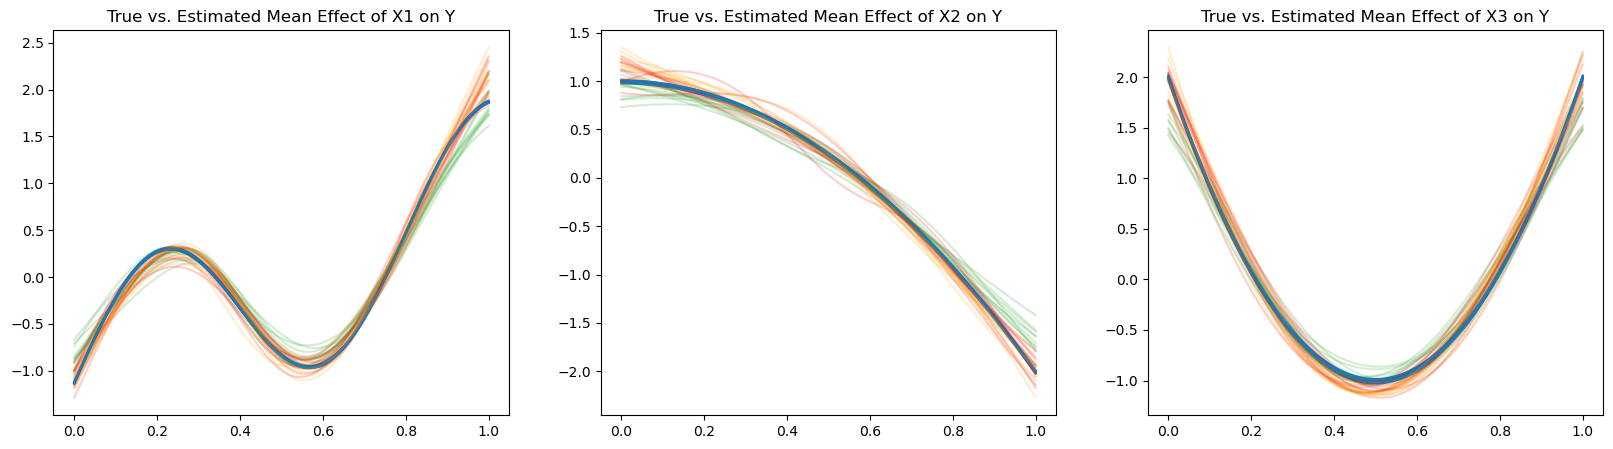

In [15]:
import matplotlib.pyplot as plt

def plot_mean_effects(sim_list):

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

    for element in sim_list:

        X_test = element["X_test"].numpy()
        F_test = element["F_test"]
        mu_components = element["mu_components"]
        robust_mu_components = element["robust_mu_components"]
        strict_mu_components = element["strict_mu_components"]

        markersize = 1
        alpha = 0.2

        true_color = "C0"
        unregulated_color = "C2"
        robust_color = "orange"
        strict_color = "red"

        X_test_sorted = X_test.copy() # Warning: X_test_sorted is not useable as covariate matrix because the columns dont relate to each other after sorting!
        F_test_sorted = F_test.copy()

        mu_components_sorted = mu_components.copy()
        robust_mu_components_sorted = robust_mu_components.copy()
        strict_mu_components_sorted = strict_mu_components.copy()

        for variable in range(0,3):

            sorted_indices = np.argsort(X_test[:,variable])
            X_test_sorted[:, variable] = X_test[sorted_indices, variable]
            F_test_sorted[:, variable] = F_test[sorted_indices, variable]

            mu_components_sorted[:, variable] = mu_components[sorted_indices, variable]
            robust_mu_components_sorted[:, variable] = robust_mu_components[sorted_indices, variable]
            strict_mu_components_sorted[:, variable] = strict_mu_components[sorted_indices, variable]


        for variable in range(0,3):
            axes[variable].plot(X_test_sorted[:,variable], (F_test_sorted[:,variable] - F_test_sorted[:,variable].mean()), color = true_color, markersize = markersize + 2)
            axes[variable].plot(X_test_sorted[:,variable], (mu_components_sorted[:,variable] - mu_components_sorted[:,variable].mean()), color = unregulated_color, markersize = markersize, alpha = alpha)
            axes[variable].plot(X_test_sorted[:,variable], (robust_mu_components_sorted[:,variable] - robust_mu_components_sorted[:,variable].mean()), color = robust_color, markersize = markersize, alpha = alpha)
            axes[variable].plot(X_test_sorted[:,variable], (strict_mu_components_sorted[:,variable] - strict_mu_components_sorted[:,variable].mean()), color = strict_color, markersize = markersize, alpha = alpha)
            axes[variable].set_title("True vs. Estimated Effect of X on Mean of Y")



In [ ]:
plot_mean_effects(simulation_list)

In [9]:
table = simulation_mse_tables(simulation_list)
table["Mean_MSE_Avg"] * 100

,X1,X2,X3
mu,1.797,1.580,1.616
robust_mu,0.949,0.776,1.254
strict_mu,0.771,0.629,1.307


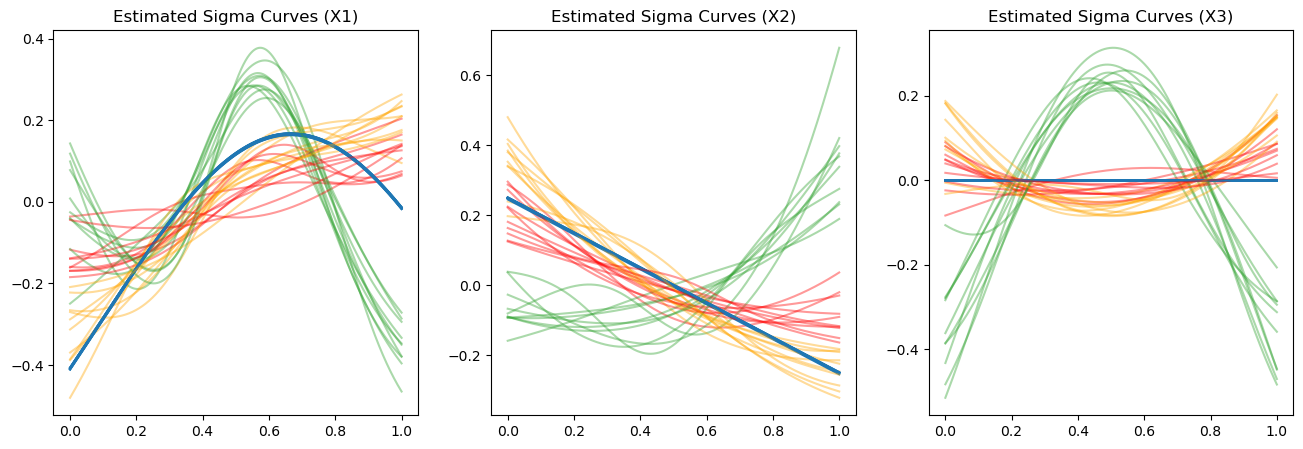

In [32]:
import matplotlib.pyplot as plt

def plot_sigma_effects(sim_list):

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

    for element in sim_list:

        X_test = element["X_test"].numpy()
        S_test = element["S_test"]
        sigma_components = element["sigma_components"]
        robust_sigma_components = element["robust_sigma_components"]
        strict_sigma_components = element["strict_sigma_components"] 

        markersize = 1
        alpha = 0.2

        true_color = "C0"
        unregulated_color = "C2"
        robust_color = "orange"
        strict_color = "red"

        X_test_sorted = X_test.copy() # Warning: X_test_sorted is not useable as covariate matrix because the columns dont relate to each other after sorting!
        S_test_sorted = S_test.copy()

        sigma_components_sorted = sigma_components.copy()
        robust_sigma_components_sorted = robust_sigma_components.copy()
        strict_sigma_components_sorted = strict_sigma_components.copy()


        for variable in range(0,3):

            sorted_indices = np.argsort(X_test[:,variable])
            X_test_sorted[:, variable] = X_test[sorted_indices, variable]
            S_test_sorted[:, variable] = S_test[sorted_indices, variable]

            sigma_components_sorted[:, variable] = sigma_components[sorted_indices, variable]
            robust_sigma_components_sorted[:, variable] = robust_sigma_components[sorted_indices, variable]
            strict_sigma_components_sorted[:, variable] = strict_sigma_components[sorted_indices, variable]

        for variable in range(0,3):
            axes[variable].plot(X_test_sorted[:,variable], (S_test_sorted[:,variable] - S_test_sorted[:,variable].mean()), color = true_color, markersize = markersize + 2)
            axes[variable].plot(X_test_sorted[:,variable], (sigma_components_sorted[:,variable] - sigma_components_sorted[:,variable].mean()), color = unregulated_color, markersize = markersize, alpha = alpha)
            axes[variable].plot(X_test_sorted[:,variable], (robust_sigma_components_sorted[:,variable] - robust_sigma_components_sorted[:,variable].mean()), color = robust_color, markersize = markersize, alpha = alpha)
            axes[variable].plot(X_test_sorted[:,variable], (strict_sigma_components_sorted[:,variable] - strict_sigma_components_sorted[:,variable].mean()), color = strict_color, markersize = markersize, alpha = alpha)
            axes[variable].set_title("True vs. Estimated Effect of X on SD(Y)")
            


In [ ]:
plot_sigma_effects(simulation_list)

In [11]:
table["Sigma_MSE_Avg"] * 100

,X1,X2,X3
sigma,3.307,7.229,3.923
robust_sigma,0.605,0.302,0.396
strict_sigma,1.192,0.526,0.112


- Mittelwert der Linien Plotten
- Aeberhardt Downweighting Proportion ausprobieren
- Reales Datenbeispiel